# Bio-Exclusive Variational Autoencoder (VAE)

This notebook builds a VAE that focuses exclusively on physiological/biological features, ignoring environmental and digital features for anomaly detection.

## Features used:
- `heart_rate`
- `stress_level`
- `body_battery`
- `sleep_duration_of_day`
- `stress_rolling_mean_30`
- `stress_volatility_30`

## Setup and Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("=" * 80)
print("BIO-EXCLUSIVE VAE - ANOMALY DETECTION")
print("=" * 80)

BIO-EXCLUSIVE VAE - ANOMALY DETECTION


## Step 1: Feature Slicing - Extract Biological Features Only

In [2]:
print("\n[STEP 1] Loading data and extracting biological features...")

# Load column names
features_df = pd.read_csv('health_net_features_2_normalize.csv', nrows=0)
column_names = features_df.columns.tolist()
print(f"Total features in dataset: {len(column_names)}")

# Define biological features we want to keep
bio_features = [
    'heart_rate',
    'stress_level', 
    'body_battery',
    'sleep_duration_of_day',
    'stress_rolling_mean_30',
    'stress_volatility_30'
]

# Find indices of biological features
bio_indices = [column_names.index(feat) for feat in bio_features]
print(f"\nBiological features selected: {bio_features}")
print(f"Feature indices: {bio_indices}")


[STEP 1] Loading data and extracting biological features...
Total features in dataset: 30

Biological features selected: ['heart_rate', 'stress_level', 'body_battery', 'sleep_duration_of_day', 'stress_rolling_mean_30', 'stress_volatility_30']
Feature indices: [7, 8, 9, 10, 19, 20]


In [3]:
# Load training and test data
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')

print(f"Original shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  X_test: {X_test.shape}")

# Slice to keep only biological features
X_train_bio = X_train[:, :, bio_indices]
X_test_bio = X_test[:, :, bio_indices]

print(f"\nBio-sliced shapes:")
print(f"  X_train_bio: {X_train_bio.shape}")
print(f"  X_test_bio: {X_test_bio.shape}")

Original shapes:
  X_train: (32728, 60, 23)
  X_test: (8183, 60, 23)

Bio-sliced shapes:
  X_train_bio: (32728, 60, 6)
  X_test_bio: (8183, 60, 6)


## Step 2: Define VAE Architecture

In [4]:
print("\n[STEP 2] Building Bio-Exclusive VAE architecture...")

# Hyperparameters
TIMESTEPS = 60
NUM_BIO_FEATURES = 6
LATENT_DIM = 2
HIDDEN_DIM = 16
LEARNING_RATE = 0.001
EPOCHS = 30
BATCH_SIZE = 32

print(f"\nHyperparameters:")
print(f"  Timesteps: {TIMESTEPS}")
print(f"  Bio Features: {NUM_BIO_FEATURES}")
print(f"  Latent Dimension: {LATENT_DIM}")
print(f"  Hidden Dimension: {HIDDEN_DIM}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch Size: {BATCH_SIZE}")


[STEP 2] Building Bio-Exclusive VAE architecture...

Hyperparameters:
  Timesteps: 60
  Bio Features: 6
  Latent Dimension: 2
  Hidden Dimension: 16
  Learning Rate: 0.001
  Epochs: 30
  Batch Size: 32


In [5]:
# Custom Sampling Layer (Reparameterization Trick)
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

print("✓ Sampling layer defined")

✓ Sampling layer defined


In [6]:
# Encoder
def build_encoder(timesteps, num_features, latent_dim, hidden_dim):
    """Build the encoder network."""
    encoder_inputs = keras.Input(shape=(timesteps, num_features), name='encoder_input')
    
    # Flatten the input
    x = layers.Flatten()(encoder_inputs)
    
    # Hidden layer
    x = layers.Dense(hidden_dim, activation='relu', name='encoder_hidden')(x)
    
    # Latent space parameters
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
    
    # Sample from latent space
    z = Sampling()([z_mean, z_log_var])
    
    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
    return encoder

print("✓ Encoder function defined")

✓ Encoder function defined


In [7]:
# Decoder
def build_decoder(timesteps, num_features, latent_dim, hidden_dim):
    """Build the decoder network."""
    latent_inputs = keras.Input(shape=(latent_dim,), name='decoder_input')
    
    # Hidden layer
    x = layers.Dense(hidden_dim, activation='relu', name='decoder_hidden')(latent_inputs)
    
    # Output layer
    x = layers.Dense(timesteps * num_features, activation='linear', name='decoder_output')(x)
    
    # Reshape to original dimensions
    decoder_outputs = layers.Reshape((timesteps, num_features))(x)
    
    decoder = Model(latent_inputs, decoder_outputs, name='decoder')
    return decoder

print("✓ Decoder function defined")

✓ Decoder function defined


In [14]:
# Custom VAE Model
class BioVAE(Model):
    """Bio-Exclusive Variational Autoencoder."""
    
    def __init__(self, encoder, decoder, **kwargs):
        super(BioVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            # Forward pass
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            # Reconstruction loss (MSE) - Direct calculation
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.square(data - reconstruction),
                    axis=(1, 2)
                )
            )
            
            # KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(
                    1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                    axis=1
                )
            )
            
            # Total loss
            total_loss = reconstruction_loss + kl_loss
        
        # Backpropagation
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def call(self, inputs):
        """Forward pass through the VAE."""
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

print("✓ BioVAE class defined")

✓ BioVAE class defined


In [15]:
# Build the model
print("\nBuilding encoder...")
encoder = build_encoder(TIMESTEPS, NUM_BIO_FEATURES, LATENT_DIM, HIDDEN_DIM)
encoder.summary()

print("\nBuilding decoder...")
decoder = build_decoder(TIMESTEPS, NUM_BIO_FEATURES, LATENT_DIM, HIDDEN_DIM)
decoder.summary()

print("\nBuilding Bio-Exclusive VAE...")
vae = BioVAE(encoder, decoder)
print("✓ VAE model created successfully!")


Building encoder...


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 60, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 360)       │          0 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_hidden      │ (None, 16)        │      5,776 │ flatten_2[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ encoder_hidden[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ encoder_hidden[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_2          │ (None, 2)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,844 (22.83 KB)

 Trainable params: 5,844 (22.83 KB)

 Non-trainable params: 0 (0.00 B)


Building decoder...


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_hidden (Dense)          │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Dense)          │ (None, 360)            │         6,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 60, 6)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,168 (24.09 KB)

 Trainable params: 6,168 (24.09 KB)

 Non-trainable params: 0 (0.00 B)


Building Bio-Exclusive VAE...
✓ VAE model created successfully!


## Step 3: Train the VAE

In [17]:
print("\n[STEP 3] Training the Bio-Exclusive VAE...")

# Compile the model
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='total_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1,
    mode='min'  # Add this line - we want to minimize the loss
)

# Train the model
history = vae.fit(
    X_train_bio,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    verbose=1
)

print("\n✓ Training complete!")


[STEP 3] Training the Bio-Exclusive VAE...
Epoch 1/30
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/step - kl_loss: 7.4696 - reconstruction_loss: 191.5830 - total_loss: 199.0526
Epoch 2/30
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 1s 766us/step - kl_loss: 6.4062 - reconstruction_loss: 182.7657 - total_loss: 189.1720
Epoch 3/30
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 1s 732us/step - kl_loss: 6.2531 - reconstruction_loss: 180.0726 - total_loss: 186.3257
Epoch 4/30
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 1s 723us/step - kl_loss: 6.0063 - reconstruction_loss: 176.9701 - total_loss: 182.9763
Epoch 5/30
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 1s 764us/step - kl_loss: 5.8482 - reconstruction_loss: 174.3095 - total_loss: 180.1577
Epoch 6/30
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 1s 775us/step - kl_loss: 5.7210 - reconstruction_loss: 171.9512 - total_loss: 177.6722
Epoch 7/30
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 1s 739us/step - kl_loss: 5.7464 - reconstruction_loss: 170.5135 - total_loss: 176.2599
Epoch 8/30
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 1s 752us/st

✓ Training history plot saved as 'bio_vae_training_history.png'


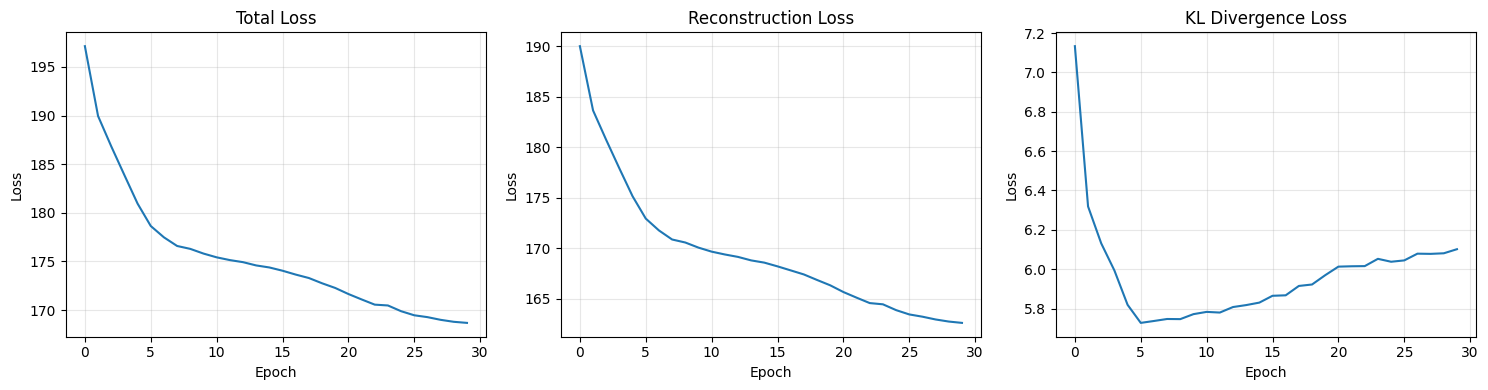

In [18]:
# Plot training history
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['total_loss'])
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(history.history['reconstruction_loss'])
plt.title('Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(history.history['kl_loss'])
plt.title('KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('bio_vae_training_history.png', dpi=150, bbox_inches='tight')
print("✓ Training history plot saved as 'bio_vae_training_history.png'")
plt.show()

## Step 4: Calculate Bio-Stability Scores

In [20]:
print("\n[STEP 4] Calculating Bio-Stability Scores...")

# Get reconstructions for test set
reconstructions = vae.predict(X_test_bio, verbose=0)

# Calculate reconstruction error (MSE) for each sample
reconstruction_errors = np.mean(np.square(X_test_bio - reconstructions), axis=(1, 2))

print(f"\nReconstruction Error Statistics:")
print(f"  Mean: {reconstruction_errors.mean():.6f}")
print(f"  Std:  {reconstruction_errors.std():.6f}")
print(f"  Min:  {reconstruction_errors.min():.6f}")
print(f"  Max:  {reconstruction_errors.max():.6f}")


[STEP 4] Calculating Bio-Stability Scores...

Reconstruction Error Statistics:
  Mean: 0.860274
  Std:  4.084783
  Min:  0.004755
  Max:  52.186541


In [21]:
# Auto-calculate scaling factor
# Target: Average score = 80 (meaning average error deducts 20 points)
TARGET_AVG_SCORE = 80.0
TARGET_AVG_DEDUCTION = 100.0 - TARGET_AVG_SCORE
mean_error = reconstruction_errors.mean()
scaling_factor = TARGET_AVG_DEDUCTION / mean_error

print(f"\nScaling Factor Calculation:")
print(f"  Target Average Score: {TARGET_AVG_SCORE}")
print(f"  Mean Reconstruction Error: {mean_error:.6f}")
print(f"  Calculated Scaling Factor: {scaling_factor:.2f}")

# Calculate Bio-Stability Scores
# Score = max(0, 100 - (Error * Scaling_Factor))
bio_stability_scores = np.maximum(0, 100 - (reconstruction_errors * scaling_factor))

print(f"\nBio-Stability Score Statistics:")
print(f"  Mean: {bio_stability_scores.mean():.2f}")
print(f"  Std:  {bio_stability_scores.std():.2f}")
print(f"  Min:  {bio_stability_scores.min():.2f}")
print(f"  Max:  {bio_stability_scores.max():.2f}")


Scaling Factor Calculation:
  Target Average Score: 80.0
  Mean Reconstruction Error: 0.860274
  Calculated Scaling Factor: 23.25

Bio-Stability Score Statistics:
  Mean: 89.60
  Std:  24.42
  Min:  0.00
  Max:  99.89


## Step 5: Save Results & Visualize

In [23]:
print("\n[STEP 5] Saving results and creating visualizations...")

# Save the scores
np.save('bio_stability_scores.npy', bio_stability_scores)
print("✓ Saved 'bio_stability_scores.npy'")

# Save the sliced test data
np.save('X_test_bio.npy', X_test_bio)
print("✓ Saved 'X_test_bio.npy'")

# Save the model
vae.save_weights('bio_vae_weights.weights.h5')
print("✓ Saved model weights as 'bio_vae_weights.h5'")


[STEP 5] Saving results and creating visualizations...
✓ Saved 'bio_stability_scores.npy'
✓ Saved 'X_test_bio.npy'
✓ Saved model weights as 'bio_vae_weights.h5'


✓ Saved visualization as 'bio_stability_scores_visualization.png'


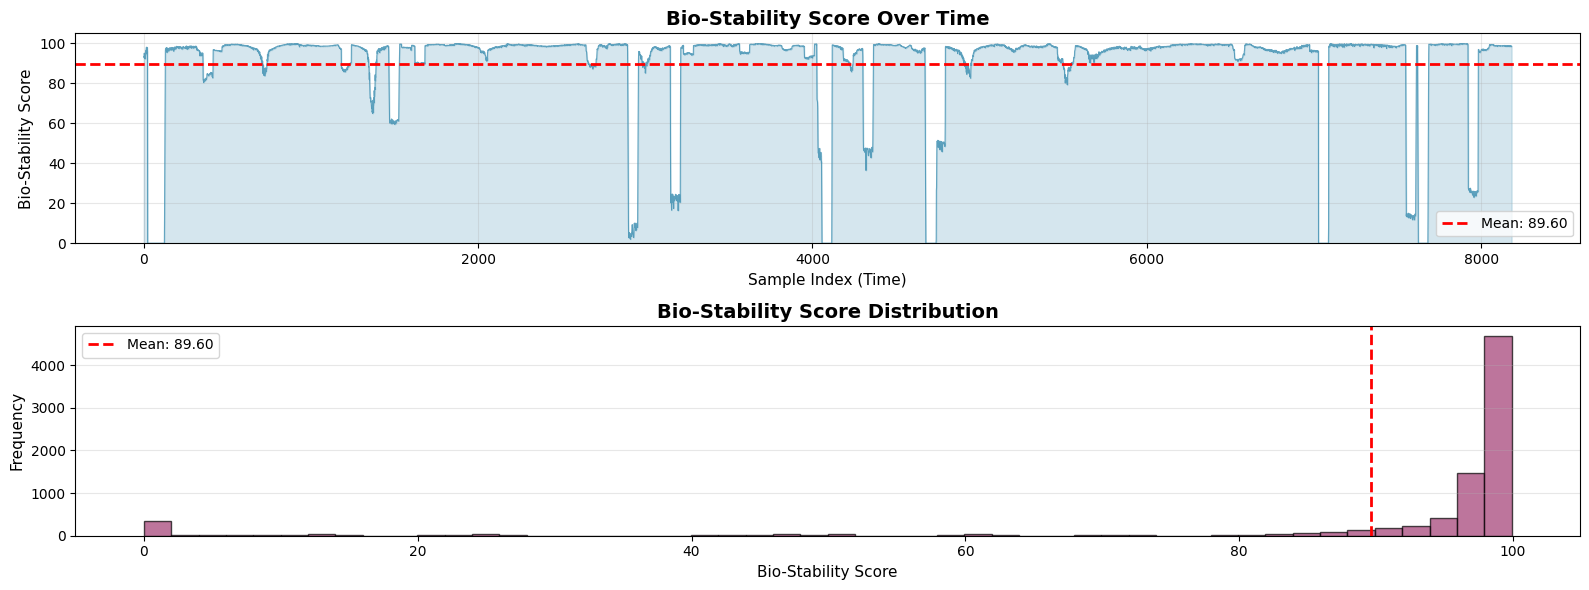

In [24]:
# Visualization 1: Bio-Stability Score Over Time
plt.figure(figsize=(16, 6))

plt.subplot(2, 1, 1)
plt.plot(bio_stability_scores, linewidth=0.8, alpha=0.7, color='#2E86AB')
plt.axhline(y=bio_stability_scores.mean(), color='red', linestyle='--', 
            label=f'Mean: {bio_stability_scores.mean():.2f}', linewidth=2)
plt.fill_between(range(len(bio_stability_scores)), 0, bio_stability_scores, 
                 alpha=0.2, color='#2E86AB')
plt.title('Bio-Stability Score Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Sample Index (Time)', fontsize=11)
plt.ylabel('Bio-Stability Score', fontsize=11)
plt.ylim(0, 105)
plt.grid(True, alpha=0.3)
plt.legend()

# Visualization 2: Score Distribution
plt.subplot(2, 1, 2)
plt.hist(bio_stability_scores, bins=50, color='#A23B72', alpha=0.7, edgecolor='black')
plt.axvline(x=bio_stability_scores.mean(), color='red', linestyle='--', 
            label=f'Mean: {bio_stability_scores.mean():.2f}', linewidth=2)
plt.title('Bio-Stability Score Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Bio-Stability Score', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.grid(True, alpha=0.3, axis='y')
plt.legend()

plt.tight_layout()
plt.savefig('bio_stability_scores_visualization.png', dpi=150, bbox_inches='tight')
print("✓ Saved visualization as 'bio_stability_scores_visualization.png'")
plt.show()

✓ Saved analysis plot as 'bio_reconstruction_analysis.png'


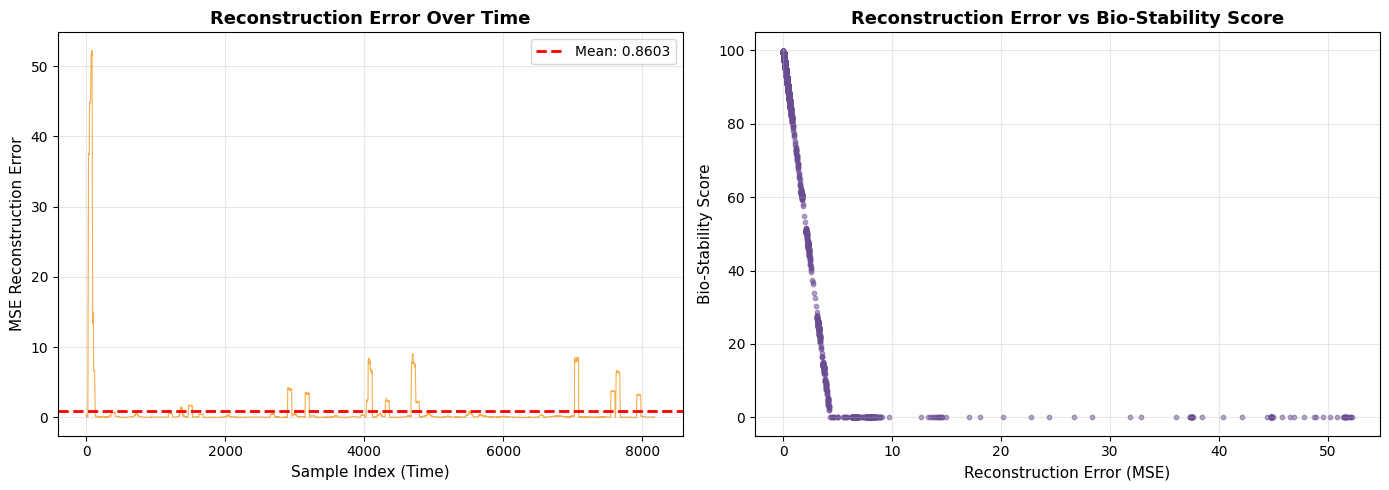

In [25]:
# Additional Visualization: Reconstruction Error vs Score
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Reconstruction Error Over Time
axes[0].plot(reconstruction_errors, linewidth=0.8, alpha=0.7, color='#F18F01')
axes[0].axhline(y=reconstruction_errors.mean(), color='red', linestyle='--', 
                label=f'Mean: {reconstruction_errors.mean():.4f}', linewidth=2)
axes[0].set_title('Reconstruction Error Over Time', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Sample Index (Time)', fontsize=11)
axes[0].set_ylabel('MSE Reconstruction Error', fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Scatter: Error vs Score
axes[1].scatter(reconstruction_errors, bio_stability_scores, alpha=0.5, s=10, color='#6A4C93')
axes[1].set_title('Reconstruction Error vs Bio-Stability Score', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Reconstruction Error (MSE)', fontsize=11)
axes[1].set_ylabel('Bio-Stability Score', fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('bio_reconstruction_analysis.png', dpi=150, bbox_inches='tight')
print("✓ Saved analysis plot as 'bio_reconstruction_analysis.png'")
plt.show()

## Summary

In [26]:
# Summary Statistics
print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)
print(f"✓ Biological features extracted: {NUM_BIO_FEATURES}")
print(f"✓ Training samples: {X_train_bio.shape[0]}")
print(f"✓ Test samples: {X_test_bio.shape[0]}")
print(f"✓ Latent dimension: {LATENT_DIM}")
print(f"✓ Average Bio-Stability Score: {bio_stability_scores.mean():.2f}")
print(f"✓ Scaling Factor: {scaling_factor:.2f}")
print(f"✓ Model trained for {len(history.history['total_loss'])} epochs")
print("=" * 80)
print("\n✓ All files saved successfully!")
print("  - bio_stability_scores.npy")
print("  - X_test_bio.npy")
print("  - bio_vae_weights.h5")
print("  - bio_vae_training_history.png")
print("  - bio_stability_scores_visualization.png")
print("  - bio_reconstruction_analysis.png")
print("\n" + "=" * 80)


SUMMARY
✓ Biological features extracted: 6
✓ Training samples: 32728
✓ Test samples: 8183
✓ Latent dimension: 2
✓ Average Bio-Stability Score: 89.60
✓ Scaling Factor: 23.25
✓ Model trained for 30 epochs

✓ All files saved successfully!
  - bio_stability_scores.npy
  - X_test_bio.npy
  - bio_vae_weights.h5
  - bio_vae_training_history.png
  - bio_stability_scores_visualization.png
  - bio_reconstruction_analysis.png



Model weights loaded successfully.
Calculating detailed breakdown...

             DETAILED BIOLOGICAL FAILURE ANALYSIS (Error Magnitude)       
            Stability_Score  heart_rate  stress_level  body_battery  sleep_duration_of_day  stress_rolling_mean_30  stress_volatility_30
Date                                                                                                                                    
2025-12-02            0.122       1.221         1.822        44.370                  0.126                   0.347                 0.033
2025-11-27            1.492       1.719        16.399       146.568                 11.583                   0.713                 0.191
2025-11-29            9.984       0.544        10.654         0.013                 11.098                   0.153                 0.770
2025-12-03           15.126       0.213        12.426         0.018                 12.931                   0.074                 0.102
2025-12-01           23.259      

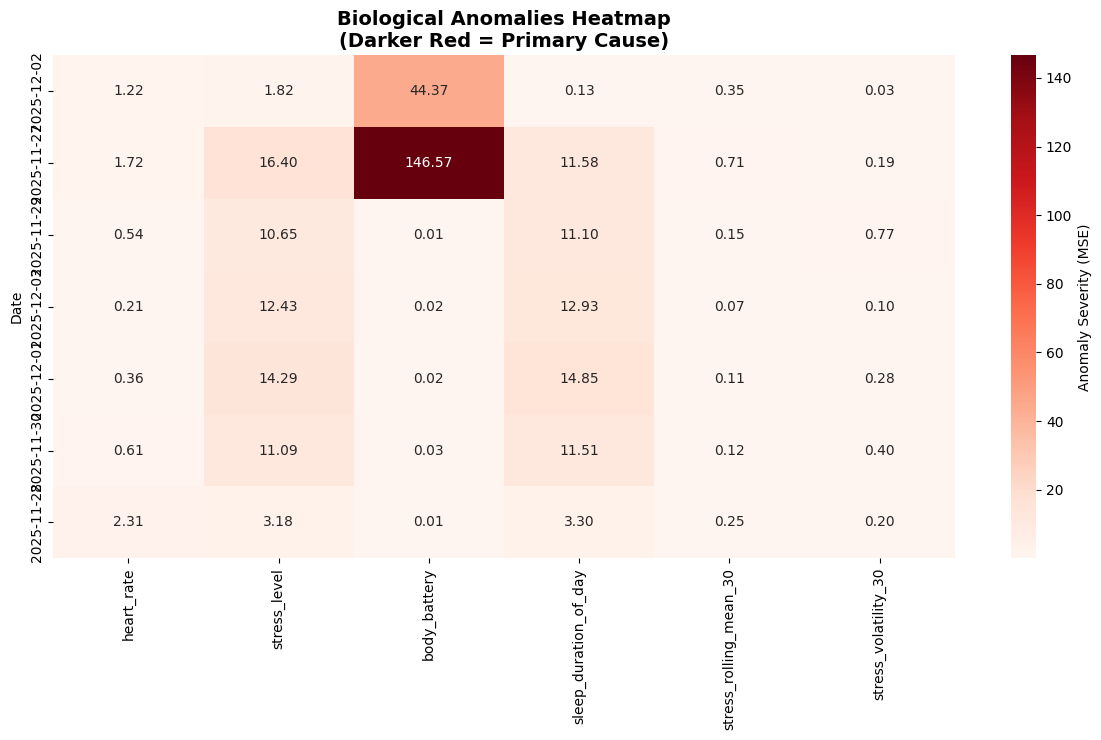

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

# ==========================================
# 1. RE-BUILD MODEL ARCHITECTURE
# ==========================================
# We must define the structure exactly as it was trained
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

# Load Data to get dimensions
X_test_bio = np.load('X_test_bio.npy')
bio_scores = np.load('bio_stability_scores.npy')
num_samples, time_steps, num_features = X_test_bio.shape
latent_dim = 2

# Build Encoder
encoder_inputs = keras.Input(shape=(time_steps, num_features))
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(16, activation='relu')(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

# Build Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(16, activation='relu')(latent_inputs)
x = layers.Dense(time_steps * num_features, activation='linear')(x)
decoder_outputs = layers.Reshape((time_steps, num_features))(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')

# Instantiate and Load Weights
vae = VAE(encoder, decoder)
# Important: Run once to initialize variables before loading weights
vae.predict(X_test_bio[:1], verbose=0) 
vae.load_weights('bio_vae_weights.weights.h5')

print("Model weights loaded successfully.")

# Load Dates for reporting
df_original = pd.read_csv('health_net_features_2_normalize.csv')
test_start_idx = len(df_original) - len(bio_scores)
test_dates = df_original['date'].iloc[test_start_idx:].reset_index(drop=True)

# Bio Features List
bio_features = [
    'heart_rate', 'stress_level', 'body_battery',
    'sleep_duration_of_day', 'stress_rolling_mean_30',
    'stress_volatility_30'
]

# ==========================================
# 2. CALCULATE DETAILED ERRORS
# ==========================================
print("Calculating detailed breakdown...")
reconstructions = vae.predict(X_test_bio, verbose=0)

# Calculate squared error for every feature
# Shape: (Samples, Features) - we average over the 60 minutes
raw_feat_errors = np.mean(np.square(X_test_bio - reconstructions), axis=1)

# Threshold for "Bad Day"
THRESHOLD = 75

detailed_data = []

for i in range(len(bio_scores)):
    if bio_scores[i] < THRESHOLD:
        # Create a dictionary for this minute
        row = {'Date': test_dates[i], 'Stability_Score': bio_scores[i]}
        
        # Add error for each feature
        for j, feat in enumerate(bio_features):
            row[feat] = raw_feat_errors[i][j]
            
        detailed_data.append(row)

if not detailed_data:
    print("No unstable days found (Score < 75).")
else:
    # Convert to DataFrame
    df_detail = pd.DataFrame(detailed_data)

    # ==========================================
    # 3. AGGREGATE BY DAY
    # ==========================================
    # Group by Date
    daily_breakdown = df_detail.groupby('Date').mean()
    
    # Sort by Score (worst first)
    daily_breakdown = daily_breakdown.sort_values(by='Stability_Score', ascending=True)

    print("\n==========================================================================")
    print(f"             DETAILED BIOLOGICAL FAILURE ANALYSIS (Error Magnitude)       ")
    print("==========================================================================")
    
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    pd.set_option('display.float_format', '{:.3f}'.format)
    
    # Re-order columns
    cols = ['Stability_Score'] + bio_features
    print(daily_breakdown[cols])
    print("==========================================================================")

    # ==========================================
    # 4. HEATMAP
    # ==========================================
    plt.figure(figsize=(12, len(daily_breakdown) * 0.5 + 4)) # Dynamic height
    
    # Heatmap data (exclude score)
    heatmap_data = daily_breakdown[bio_features]
    
    sns.heatmap(heatmap_data, annot=True, cmap='Reds', fmt='.2f', 
                cbar_kws={'label': 'Anomaly Severity (MSE)'})
    
    plt.title('Biological Anomalies Heatmap\n(Darker Red = Primary Cause)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()